In [22]:
!pip install opendatasets
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm



import opendatasets as od


## import library
import numpy as np
import os
import random
import sys
from pycocotools.coco import COCO
import urllib
import zipfile
import shutil
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import pandas


In [46]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/mlops/hw2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/mlops/hw2


In [25]:
# od.download(
#     "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [47]:

model = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)


In [49]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [50]:
#/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/train

#/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/train
imgs_path = ['/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/train/',
                '/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/test/',
                '/content/drive/MyDrive/mlops/hw2/chest-xray-pneumonia/chest_xray/val/']

file_list_ = []
for img_path in imgs_path:
 
  file_list = glob.glob(img_path + "*")
  for i in file_list: 
    file_list_.append(i)

data = []

for class_path in file_list_:
            class_name = class_path.split("/")[-1]
            filenames = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            for img_path in filenames:
                data.append([class_path+"/"+img_path, class_name])
print("number of all data:",len(data))


number of all data: 5856


In [51]:
from sklearn.model_selection import train_test_split

# Split data into 80% train and 20% test
train, test = train_test_split(data, test_size=0.2)

val, test = train_test_split(test, test_size=0.5)

# # Extract the image links and labels from the train and test sets
# train_images = [item[0] for item in train]
# train_labels = [item[1] for item in train]
# test_images = [item[0] for item in test]
# test_labels = [item[1] for item in test]

print('# train :',len(train))
print('# val :',len(val))
print('# test :',len(test))

# train : 4684
# val : 586
# test : 586


In [52]:
import torchvision.transforms as T
class CustomDataset(Dataset):
    def __init__(self,data, transform):
        self.data = data
        self.class_map = {"NORMAL" : 0, "PNEUMONIA": 1}
        self.img_dim = (224, 224)

    def rotateImage(image, angle):
      row,col = (228,228)
      center=tuple(np.array([row,col])/2)
      rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
      new_image = cv2.warpAffine(image, rot_mat, (col,row))
      return new_image        
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        transform = T.RandomHorizontalFlip()
        if transform is True:
          self.img = rotateImage(img ,random.randint(0, 30))
          self.img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
          img = transform(img)
        
        else:
          self.img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        #img = self.transform(img)
        #print(img.shape)
        # img = cv2.imread(img_path)
        # img = cv2.resize(img, self.img_dim)
        img_tensor = torch.from_numpy(img)
        # #img = self.transform(img)
        class_id = self.class_map[class_name]
        # #img_tensor = torch.from_numpy(img)
        '''For this conversion we use the permute function of torch,
            that allows us to change the ordering of the dimensions of a torch tensor. 
            The arguments we pass to it, correspond to the new ordering of dimensions we want.
            For example in our case, we have (Width, Height, Channels).
            (Width -> 0), (Height->1), (Channels->2)
              We want to reorder these dimensions to make channels first, therefore,
              we use img_tensor.permute(2, 0, 1), which would make the 2nd dimension first.'''
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id , img_path


     

In [53]:
batch_size = 16

dataset = CustomDataset(train,transform = True )		
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = CustomDataset(val ,transform = False)		
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = CustomDataset(test,transform = False)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [54]:
x = nn.Sigmoid()

In [77]:
def test_set(test_loader):
  y_true = []
  y_pred = []
  Images_path = []

  # Load the best model weights and evaluate on the test set
  model.eval()

  test_loss = 0.0
  test_corrects = 0
  with torch.no_grad():
      for inputs, labels , img_path in tqdm(test_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          #print("yr")
          outputs = model(inputs.float())
          outputs = x(outputs)
          pred =torch.round(outputs.detach())
          target = torch.round(labels.detach())
          y_pred.extend(pred.tolist())
          y_true.extend(target.tolist())
          Images_path.extend(img_path)
  return y_pred , y_true , Images_path

In [78]:
True_link_image_pred = []
False_link_image_pred = []
y_pred , y_true , Images_path = test_set(test_loader)

for i in range(len(Images_path)):
  if y_pred[i] != y_true[i] :
      #print([y_pred[i],y_true[i]])
      False_link_image_pred.append([Images_path[i],y_true[i]])
  else :
      True_link_image_pred.append([Images_path[i],y_true[i]])
          

100%|██████████| 37/37 [00:18<00:00,  1.98it/s]


In [79]:
len(False_link_image_pred)

35

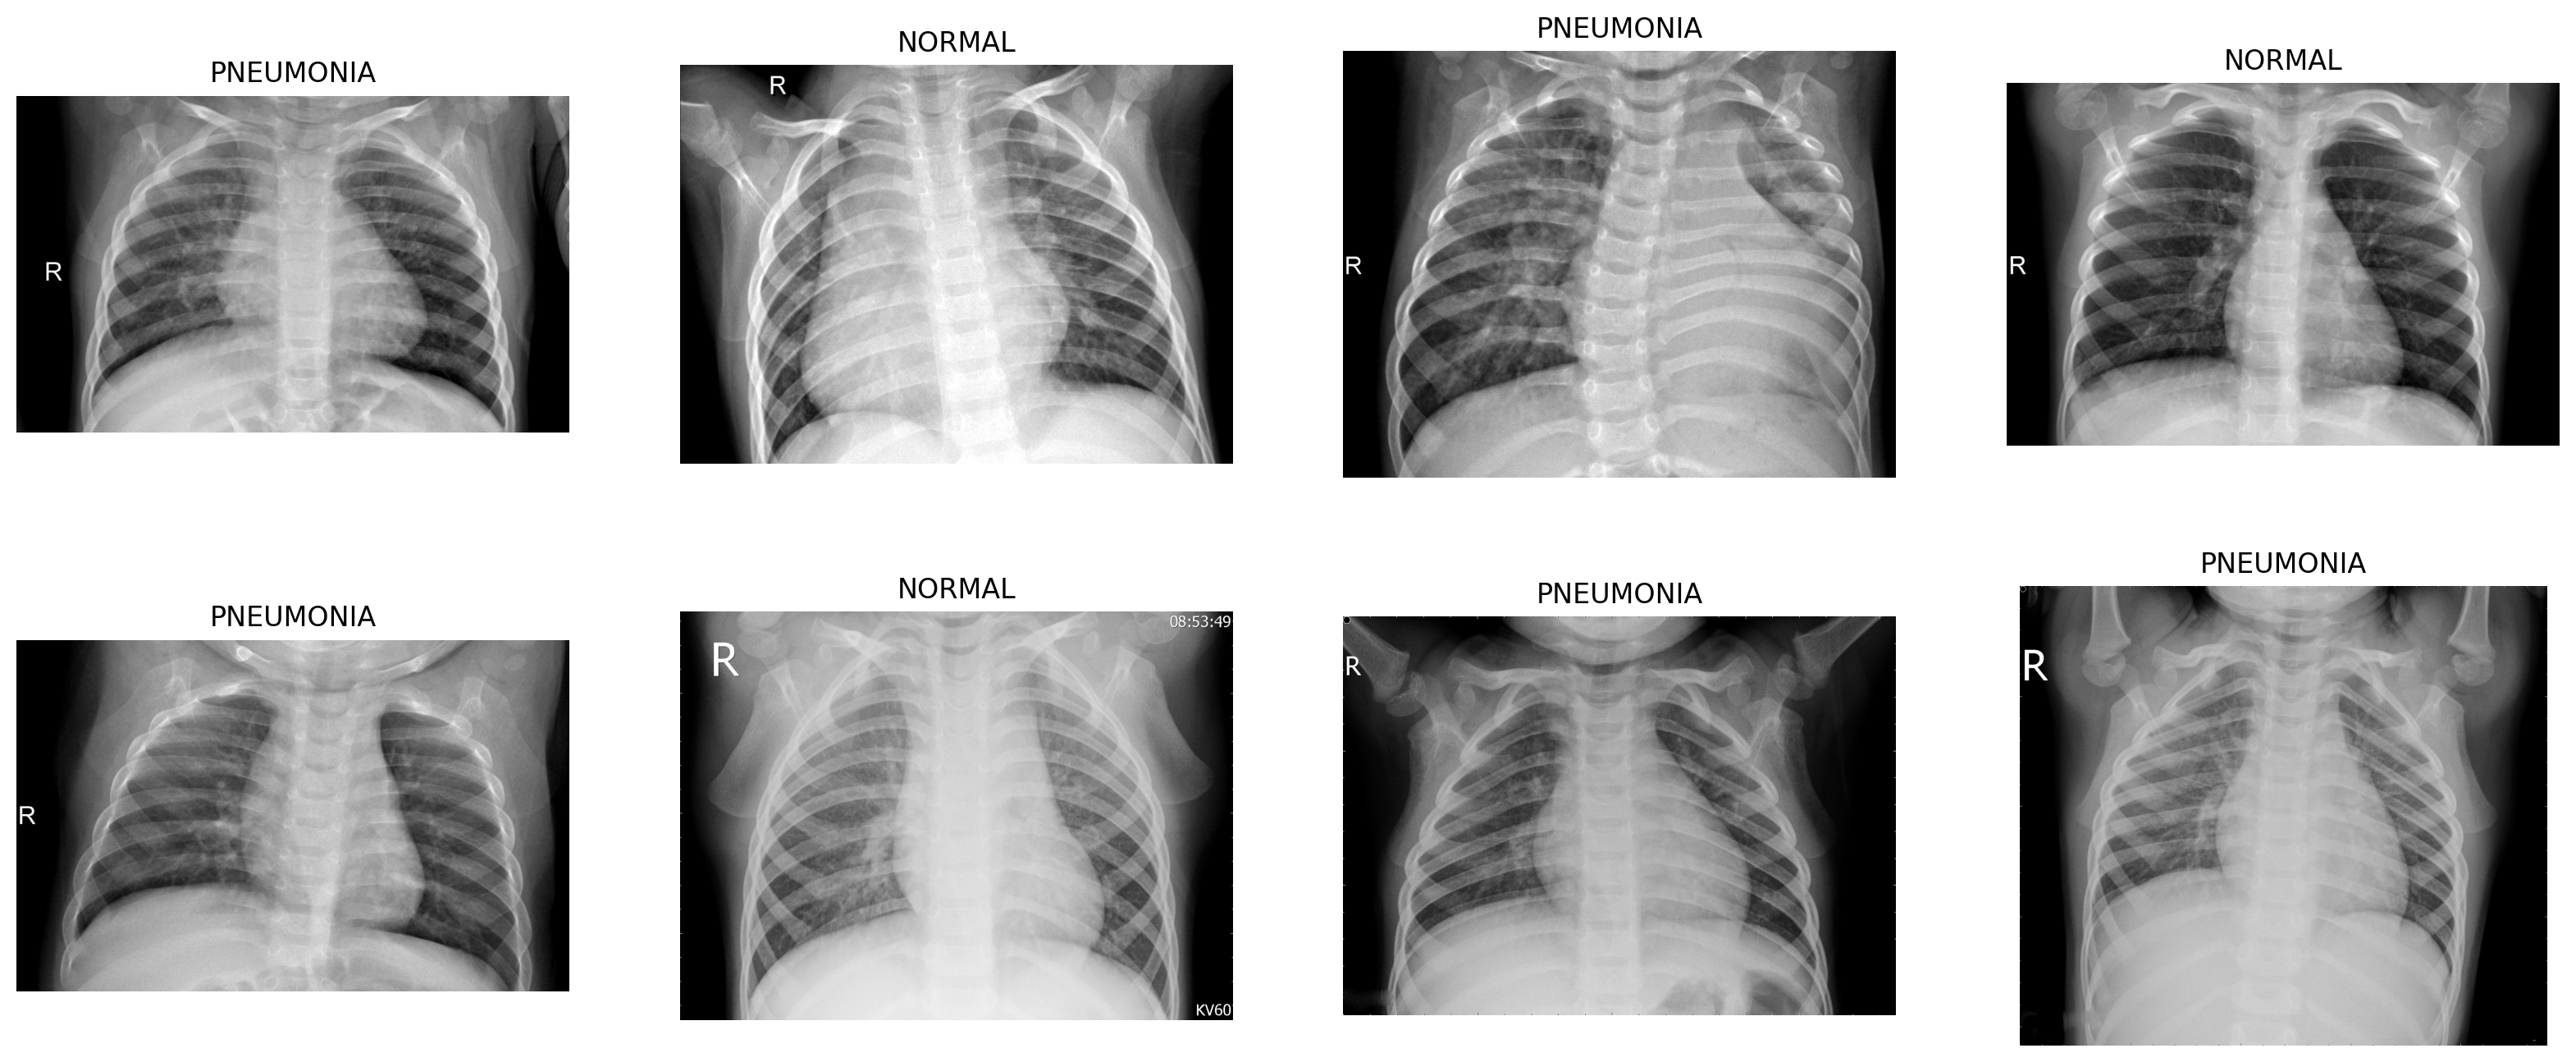

In [80]:
i = 0 
plt.figure(figsize=(20,8))
for img_path , class_name  in False_link_image_pred[16 : 24]:
    #print(img_path.shape)
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(False_link_image_pred[i][0])
    plt.imshow(img, cmap='gray')
    
    if class_name == [1] :
      class_name = "PNEUMONIA"
    else : 
      class_name ="NORMAL"
    #plt.imshow(img, cmap='gray')
    plt.title(class_name)
    i += 1
 

In [81]:
import sys
from PIL import Image
from matplotlib import cm

brightness_true =[]
brightness_false =[]

def calculate_brightness(image):
    greyscale_image = image.convert('L')
    histogram = greyscale_image.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 else brightness / scale

for i in range(len(False_link_image_pred)):
  #img = False_link_image_pred[i][0].permute(1, 2, 0).cpu().numpy()
  img = Image.open(False_link_image_pred[i][0])
  #img = Image. fromarray(img, 'RGB')
  brightness_false.append(calculate_brightness(img))
  
for i in range(len(True_link_image_pred)):
  
  img = Image.open(True_link_image_pred[i][0])
  brightness_true.append(calculate_brightness(img))


In [41]:
 !mkdir chanded_berighness

In [83]:
!mkdir 00
!mkdir 11

In [86]:
changed_brightness_image=[]
mean_brightness_true_pred = 0.4823

# Load the image as a numpy arra
for i in range(len(False_link_image_pred)):
  
  image = plt.imread(False_link_image_pred[i][0])
  image_ = Image.open(True_link_image_pred[i][0])
  
  #image =  False_link_image_pred[i][0].permute(1, 2, 0).cpu().numpy()
  #image_ = Image. fromarray(image, 'RGB')
  label = False_link_image_pred[i][1]

  alfa = mean_brightness_true_pred / calculate_brightness(image_)

  # Multiply the array by alfa to increase the brightness by 20%
  bright_image = image * alfa 

  # Clip the values to the range [0, 255] to avoid overflow
  bright_image = np.clip(bright_image, 0, 255)

  # Convert the array to uint8 type
  bright_image = bright_image.astype(np.uint8)


  # Save the brightened image as "bright_image.jpg"

  name =  str(label[0])+str(label[0])+ "/"+str(i) + "bright_image.jpg"
  plt.imsave( name , bright_image)




  

In [87]:
file_list_=["/content/drive/MyDrive/mlops/hw2/chanded_berighness/00","/content/drive/MyDrive/mlops/hw2/chanded_berighness/11"]
data = []

for class_path in file_list_:
            class_name = class_path.split("/")[-1]
            if class_name == "0" :
              class_name = "NORMAL"
            else : 
               class_name = "PNEUMONIA"

            
            filenames = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            for img_path in filenames:
                data.append([class_path+"/"+img_path, class_name])
print("number of all data:",len(data))


number of all data: 35


In [88]:

dataset = CustomDataset(data ,transform = False)		
test_loader_ = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [89]:
True_link_image_pred_ = []
False_link_image_pred_ = []
y_pred_ , y_true_ , Images_path_ = test_set(test_loader_)

for i in range(len(Images_path_)):
  if y_pred_[i] != y_true_[i] :
      #print([y_pred[i],y_true[i]])
      False_link_image_pred_.append([Images_path_[i],y_true[i]])
  else :
      True_link_image_pred_.append([Images_path_[i],y_true[i]])

100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


In [90]:
len(False_link_image_pred_)

0

In [91]:
len(True_link_image_pred_)

35